In [75]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import precision_recall_curve, roc_auc_score, f1_score, balanced_accuracy_score, precision_score, recall_score, auc
import shap
import muon as mu
from muon import MuData
import numpy as np

# Load your muon data objects (assuming they are stored in CSV files)
tmt_brain = mu.read('mudata_prepared_trial1/TMT_CSF_mudata.h5mu')

# Ensure 'Group' column is consistently named
proteomics = tmt_brain["proteomics"]
proteomics.obs["group"] = proteomics.obs["group"].map({'Control': 0, 'AD': 1})

clinical = tmt_brain["clinical"]


# Convert 'group' column to numeric
proteomics.obs["group"] = pd.to_numeric(proteomics.obs["group"])

# Print the shape of the combined data
print(clinical.var)
print(proteomics.obs)

Empty DataFrame
Columns: []
Index: [0, 1, 2, 3, 4]
              group
sample ids         
TMT1_b1.127C      1
TMT1_b1.127N      0
TMT1_b1.128C      1
TMT1_b1.128N      0
TMT1_b1.129C      0
...             ...
TMT4_b5.129C      0
TMT4_b5.129N      1
TMT4_b5.130C      0
TMT4_b5.130N      0
TMT4_b5.131C      1

[784 rows x 1 columns]


/opt/anaconda3/lib/python3.12/site-packages/mudata/_core/mudata.py:1531: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/opt/anaconda3/lib/python3.12/site-packages/mudata/_core/mudata.py:1429: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("obs", axis=1, join_common=join_common)


In [76]:
# Extract proteomics modality
proteomics = tmt_brain["proteomics"]
clinical = tmt_brain["clinical"]    
# Combine the data into a single DataFrame
import numpy as np
import pandas as pd

# Extract features from clinical modality
X_clinical = clinical.X if isinstance(clinical.X, np.ndarray) else clinical.X.toarray()
X_clinical = pd.DataFrame(clinical.obs)

# Extract features from proteomics modality
X_proteomics = proteomics.X if isinstance(proteomics.X, np.ndarray) else proteomics.X.toarray()
X_proteomics = pd.DataFrame(X_proteomics, columns=proteomics.var_names, index=proteomics.obs_names)


# Align samples (obs_names) across modalities
common_samples = clinical.obs_names.intersection(proteomics.obs_names)
X_clinical = X_clinical.loc[common_samples]
X_proteomics = X_proteomics.loc[common_samples]

# Extract 'group' column as the target variable (y)
y = proteomics.obs.loc[common_samples, 'group']  # Assuming 'group' is in obs

# Remove 'group' column from proteomics features if it exists in var
if 'group' in X_proteomics.columns:
    X_proteomics = X_proteomics.drop(columns=['group'])

# Concatenate features from both modalities
X = pd.concat([X_clinical, X_proteomics], axis=1)

# Result: X contains features, and y contains labels
print("Feature matrix shape:", X.shape)
print("Target vector shape:", y.shape)

   
print(X)
print(y)

if not X.index.equals(y.index):
    print("The indexes are not equal")  



Feature matrix shape: (784, 170)
Target vector shape: (784,)
               age  sex  Abeta42       pTau    tTau     p01024     p01023  \
sample ids                                                                  
TMT1_b1.127C  66.8    0   666.90  33.780000  358.20  13.844427  10.443757   
TMT1_b1.127N  69.5    1   835.30  12.110000  129.70  14.484561  10.258901   
TMT1_b1.128C  70.3    0   470.70  34.320000  317.60  13.663189  10.508492   
TMT1_b1.128N  51.3    1   768.50   8.000000   83.66  13.075341  11.009359   
TMT1_b1.129C  72.1    1  1700.00  17.010000  185.60  13.499626  10.382265   
...            ...  ...      ...        ...     ...        ...        ...   
TMT4_b5.129C  79.0    1   650.64  19.481681   79.92  13.686515  10.395174   
TMT4_b5.129N  61.0    0   206.43  63.134782  157.77  13.943415  10.347471   
TMT4_b5.130C  72.0    1   598.98  23.871942   59.75  13.653392  10.388173   
TMT4_b5.130N  64.0    1   495.68  24.026545   45.22  13.857042  10.124292   
TMT4_b5.131C  5

In [77]:
X = X.drop(columns=["Abeta42", "pTau", "tTau"])


In [78]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, balanced_accuracy_score, roc_auc_score, precision_recall_curve, auc, make_scorer
from imblearn.over_sampling import SMOTE
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import f1_score, make_scorer
from imblearn.over_sampling import SMOTE

# Initialize models with balanced class weight
rf_model = RandomForestClassifier(class_weight='balanced', 
                                  n_estimators=100, 
                                  max_depth=10, 
                                  min_samples_split=10, 
                                  min_samples_leaf=5, 
                                  max_features='sqrt', 
                                  random_state=42)

# Implement Logistic Regression with Gradient Descent (SGDClassifier)
lr_model = SGDClassifier(loss='log_loss',  # Corrected loss parameter
                          class_weight='balanced',
                          max_iter=5000,  # More iterations to ensure convergence
                          tol=1e-4,  # Convergence tolerance
                          learning_rate='optimal',  # Adaptive learning rate
                          random_state=42)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Apply SMOTE (Oversampling) to balance class distribution
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# Cross-validation strategy
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Store metrics for all models
model_results = []

# Feature counts to explore
feature_counts = range(5, 26)

# Parameter grids
param_grid_rf = {'n_estimators': [100, 200], 'min_samples_split': [2, 5]}
param_grid_lr = {'alpha': [0.0001, 0.001, 0.01]}  # Regularization strength for SGDClassifier

# Custom loss function to penalize misclassifying Control (0)
def weighted_f1(y_true, y_pred):
    f1_control = f1_score(y_true[y_true == 0], y_pred[y_true == 0], zero_division=1)
    f1_ad = f1_score(y_true[y_true == 1], y_pred[y_true == 1], zero_division=1)
    return (2 * f1_control + f1_ad) / 3  # More weight on Control class

scorer = make_scorer(weighted_f1, greater_is_better=True)

for num_features in feature_counts:
    # Feature selection inside cross-validation
    rf_selector = SelectFromModel(rf_model, threshold=-np.inf, max_features=num_features).fit(X_train, y_train)
    X_train_selected = rf_selector.transform(X_train)
    X_test_selected = rf_selector.transform(X_test)

    # Train & Tune RandomForestClassifier
    grid_search_rf = GridSearchCV(rf_model, param_grid_rf, cv=inner_cv, scoring='f1', n_jobs=-1)
    grid_search_rf.fit(X_train_selected, y_train)
    best_rf_model = grid_search_rf.best_estimator_

    # Model Calibration
    calibrated_rf = CalibratedClassifierCV(best_rf_model, method='sigmoid', cv=inner_cv)
    calibrated_rf.fit(X_train_selected, y_train)
    y_pred_proba_rf = calibrated_rf.predict_proba(X_test_selected)[:, 1]

    # Tune decision threshold
    precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba_rf)
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-9)
    best_threshold = thresholds[np.argmax(f1_scores)]

    y_pred_rf = (y_pred_proba_rf >= best_threshold).astype(int)

    model_results.append({
        'Model': 'RandomForest',
        'Precision': precision_score(y_test, y_pred_rf),
        'Recall': recall_score(y_test, y_pred_rf),
        'F1 Score': f1_score(y_test, y_pred_rf, zero_division=1),
        'Balanced Accuracy': balanced_accuracy_score(y_test, y_pred_rf),
        'ROC AUC': roc_auc_score(y_test, y_pred_proba_rf),
        'AUC-PR': auc(recalls, precisions),
        'Num Features': num_features,
        'Best Threshold': best_threshold
    })

    # Train & Tune Logistic Regression (SGDClassifier)
    grid_search_lr = GridSearchCV(lr_model, param_grid_lr, cv=inner_cv, scoring=scorer, n_jobs=-1)
    grid_search_lr.fit(X_train_selected, y_train)
    best_lr_model = grid_search_lr.best_estimator_

    # Model Calibration
    calibrated_lr = CalibratedClassifierCV(best_lr_model, method='sigmoid', cv=inner_cv)
    calibrated_lr.fit(X_train_selected, y_train)
    y_pred_proba_lr = calibrated_lr.predict_proba(X_test_selected)[:, 1]

    # Tune decision threshold
    precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba_lr)
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-9)
    best_threshold = thresholds[np.argmax(f1_scores)]

    y_pred_lr = (y_pred_proba_lr >= best_threshold).astype(int)

    model_results.append({
        'Model': 'SGD Logistic Regression',
        'Precision': precision_score(y_test, y_pred_lr),
        'Recall': recall_score(y_test, y_pred_lr),
        'F1 Score': f1_score(y_test, y_pred_lr),
        'Balanced Accuracy': balanced_accuracy_score(y_test, y_pred_lr),
        'ROC AUC': roc_auc_score(y_test, y_pred_proba_lr),
        'AUC-PR': auc(recalls, precisions),
        'Num Features': num_features,
        'Best Threshold': best_threshold
    })

# Convert results to DataFrame
results_df = pd.DataFrame(model_results)


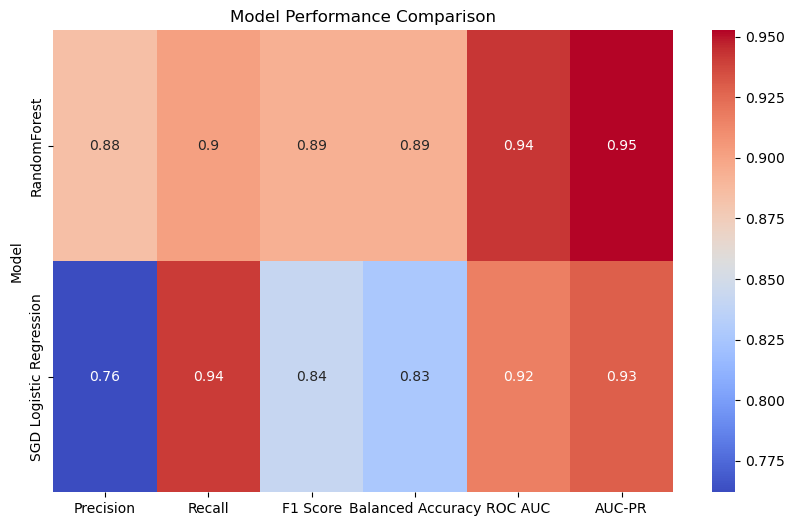

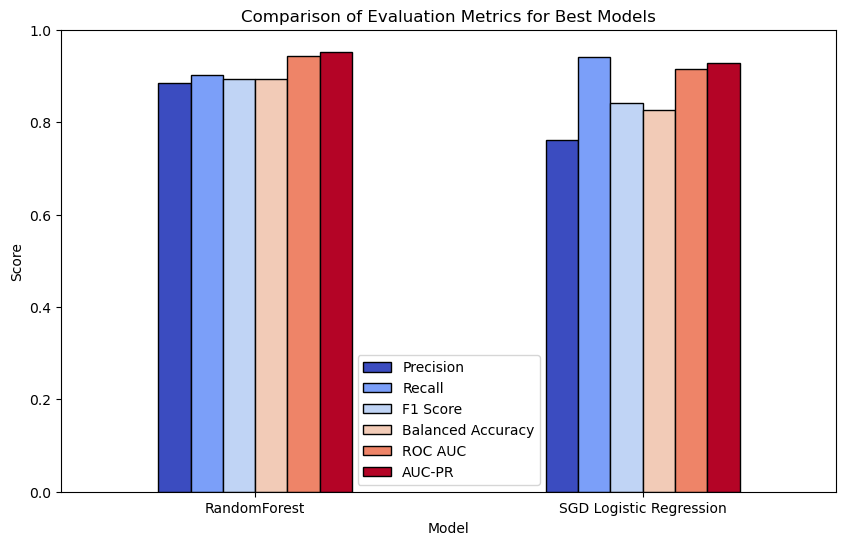

In [74]:
import matplotlib.pyplot as plt
import seaborn as sns

# ✅ Extract the best RF and LR (SGD) models based on AUC-PR and F1 Score
best_rf = results_df[results_df['Model'] == 'RandomForest'].sort_values(by=['AUC-PR', 'F1 Score'], ascending=[False, False]).iloc[0]
best_lr = results_df[results_df['Model'] == 'SGD Logistic Regression'].sort_values(by=['AUC-PR', 'F1 Score'], ascending=[False, False]).iloc[0]

# ✅ Combine results into a DataFrame for visualization
best_models_df = pd.DataFrame([best_rf, best_lr])

# ✅ Heatmap of Performance Metrics
plt.figure(figsize=(10, 6))
sns.heatmap(best_models_df.set_index('Model')[['Precision', 'Recall', 'F1 Score', 'Balanced Accuracy', 'ROC AUC', 'AUC-PR']], 
            annot=True, cmap='coolwarm', cbar=True)
plt.title('Model Performance Comparison')
plt.show()

# ✅ Bar Plot for Model Performance Comparison
metrics = ['Precision', 'Recall', 'F1 Score', 'Balanced Accuracy', 'ROC AUC', 'AUC-PR']
best_models_df.set_index("Model")[metrics].plot(kind='bar', figsize=(10, 6), colormap="coolwarm", edgecolor="black")
plt.title("Comparison of Evaluation Metrics for Best Models")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.legend(loc="best")
plt.show()


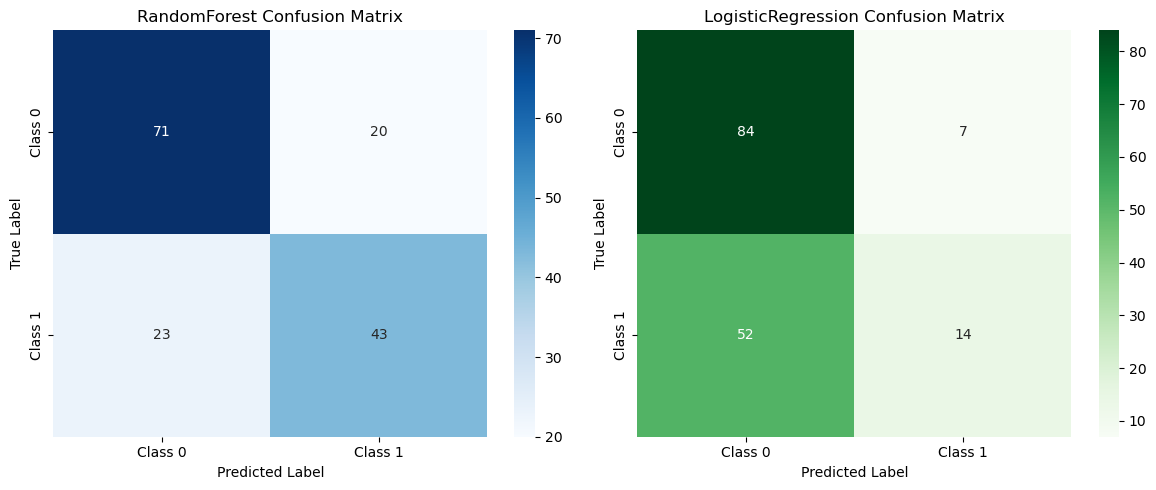

In [65]:
from sklearn.metrics import confusion_matrix  # Import added to fix NameError

# Use the best models identified earlier
best_rf_model = best_rf_model  # Best RandomForest model
best_lr_model = best_lr_model  # Best LogisticRegression model

# Generate predictions for test data
y_pred_rf = best_rf_model.predict(X_test_selected)
y_pred_lr = best_lr_model.predict(X_test_selected)

# Compute confusion matrices
cm_rf = confusion_matrix(y_test, y_pred_rf)
cm_lr = confusion_matrix(y_test, y_pred_lr)

labels = ['Class 0', 'Class 1']  # Adjust based on your dataset

# Plot confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# RandomForest Confusion Matrix
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=axes[0])
axes[0].set_title('RandomForest Confusion Matrix')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')

# LogisticRegression Confusion Matrix
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Greens', xticklabels=labels, yticklabels=labels, ax=axes[1])
axes[1].set_title('LogisticRegression Confusion Matrix')
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')

plt.tight_layout()
plt.show()